# Kalman filter run with varying amounts of training data

## User Options

Define what folder you're saving to

In [1]:
# save_folder=''
save_folder='/home/jglaser/Files/Neural_Decoding/Results/'

Define what folder you're loading the files from

In [2]:
# load_folder=''
load_folder='/home/jglaser/Data/DecData/'

Define what dataset you're using

In [3]:
dataset='s1'
# dataset='m1'
# dataset='hc'

## 1. Import Packages

We import both standard packages, and functions from the accompanying .py files

In [4]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys
import time

#Add the main folder to the path, so we have access to the files there.
#Note that if your working directory is not the Paper_code folder, you may need to manually specify the path to the main folder. For example: sys.path.append('/home/jglaser/GitProj/Neural_Decoding')
sys.path.append('..') 

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import metrics
from metrics import get_R2
from metrics import get_rho

#Import decoder functions
from decoders import KalmanFilterDecoder

from bayes_opt import BayesianOptimization

/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 45.0% of memory, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5103, 5110))
/opt/anaconda/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be t

In [5]:
#Turn off deprecation warnings

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 2. Load Data

The data that we load is in the format described below. We have another example script, "neural_preprocessing.py" that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [6]:
if dataset=='s1':
    with open(load_folder+'example_data_s1.pickle','rb') as f:
    #     neural_data,vels_binned=pickle.load(f,encoding='latin1')
        neural_data,vels_binned=pickle.load(f)
        
if dataset=='m1':
    with open(load_folder+'example_data_m1.pickle','rb') as f:
    #     neural_data,vels_binned=pickle.load(f,encoding='latin1')
        neural_data,vels_binned=pickle.load(f)
        
if dataset=='hc':
    with open(load_folder+'example_data_hc.pickle','rb') as f:
    #     neural_data,pos_binned=pickle.load(f,encoding='latin1')
        neural_data,pos_binned=pickle.load(f)

## 3. Preprocess Data

### 3B. Format Covariates

#### Format Input Covariates

In [7]:
#Remove neurons with too few spikes in HC dataset
if dataset=='hc':
    nd_sum=np.nansum(neural_data,axis=0)
    rmv_nrn=np.where(nd_sum<100)
    neural_data=np.delete(neural_data,rmv_nrn,1)

In [8]:
#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=neural_data

#### Format Output Covariates

In [9]:
#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (s1 or m1) or position (hc)
#But using them all as covariates helps performance

if dataset=='s1' or dataset=='m1':

    #We will now determine position
    pos_binned=np.zeros(vels_binned.shape) #Initialize 
    pos_binned[0,:]=0 #Assume starting position is at [0,0]
    #Loop through time bins and determine positions based on the velocities
    for i in range(pos_binned.shape[0]-1): 
        pos_binned[i+1,0]=pos_binned[i,0]+vels_binned[i,0]*.05 #Note that .05 is the length of the time bin
        pos_binned[i+1,1]=pos_binned[i,1]+vels_binned[i,1]*.05

    #We will now determine acceleration    
    temp=np.diff(vels_binned,axis=0) #The acceleration is the difference in velocities across time bins 
    acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0) #Assume acceleration at last time point is same as 2nd to last

    #The final output covariates include position, velocity, and acceleration
    y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)


if dataset=='hc':

    temp=np.diff(pos_binned,axis=0)
    vels_binned=np.concatenate((temp,temp[-1:,:]),axis=0)

    temp2=np.diff(vels_binned,axis=0)
    acc_binned=np.concatenate((temp2,temp2[-1:,:]),axis=0)

    y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

In [10]:
if dataset=='hc':
    #Remove time bins with no output (y value)
    rmv_time=np.where(np.isnan(y_kf[:,0]) | np.isnan(y_kf[:,1]))
    X_kf=np.delete(X_kf,rmv_time,0)
    y_kf=np.delete(y_kf,rmv_time,0)

### 3C. Define training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

In [11]:
#Bin size
if dataset=='s1' or dataset=='m1':
    dt=.05
if dataset=='hc':
    dt=.2

if dataset=='hc':
    
    #Size of sets
    test_size=int(450/dt) #7.5 min
    valid_size=test_size #validation size is the same as the test size
    train_size_min=test_size #The minimum training size
    
    #End indices
    end_idx=np.int(X_kf.shape[0]*.8) #End of test set
    tr_end_idx=end_idx-test_size-valid_size #End of training set

    #Range of sets
    testing_range=[end_idx-test_size,end_idx] #Testing set (length of test_size, goes up until end_idx)
    valid_range=[end_idx-test_size-valid_size,end_idx-test_size] #Validation set (length of valid_size, goes up until beginning of test set)
    #Below is a list with the range of all training sets tested
    training_range_all=[[tr_end_idx-1*train_size_min,tr_end_idx],[tr_end_idx-2*train_size_min,tr_end_idx],[tr_end_idx-3*train_size_min,tr_end_idx],[tr_end_idx-4*train_size_min,tr_end_idx],[tr_end_idx-5*train_size_min,tr_end_idx]]


if dataset=='s1':
  
    #Size of sets
    test_size=int(300/dt) #5 min
    valid_size=test_size
    train_size_min=int(60/dt) # 1 min, the minimum training size
    
    #End indices    
    end_idx=np.int(X_kf.shape[0]*.9)
    tr_end_idx=end_idx-test_size-valid_size    
    
    #Range of sets
    testing_range=[end_idx-test_size,end_idx] #Testing set (length of test_size, goes up until end_idx)
    valid_range=[end_idx-test_size-valid_size,end_idx-test_size] #Validation set (length of valid_size, goes up until beginning of test set)
    #Below is a list with the range of all training sets tested
    training_range_all=[[tr_end_idx-1*train_size_min,tr_end_idx],[tr_end_idx-2*train_size_min,tr_end_idx],[tr_end_idx-3*train_size_min,tr_end_idx],[tr_end_idx-4*train_size_min,tr_end_idx],[tr_end_idx-5*train_size_min,tr_end_idx],[tr_end_idx-10*train_size_min,tr_end_idx],[tr_end_idx-20*train_size_min,tr_end_idx]]


if dataset=='m1':
    
    #Size of sets
    test_size=int(300/dt) #5 min
    valid_size=test_size
    train_size_min=int(60/dt) # 1 min, the minimum training size
    
    #End indices    
    end_idx=np.int(X_kf.shape[0]*1)
    tr_end_idx=end_idx-test_size-valid_size      

    #Range of sets
    testing_range=[end_idx-test_size,end_idx] #Testing set (length of test_size, goes up until end_idx)
    valid_range=[end_idx-test_size-valid_size,end_idx-test_size] #Validation set (length of valid_size, goes up until beginning of test set)
    #Below is a list with the range of all training sets tested    
    training_range_all=[[tr_end_idx-1*train_size_min,tr_end_idx],[tr_end_idx-2*train_size_min,tr_end_idx],[tr_end_idx-3*train_size_min,tr_end_idx],[tr_end_idx-4*train_size_min,tr_end_idx],[tr_end_idx-5*train_size_min,tr_end_idx],[tr_end_idx-10*train_size_min,tr_end_idx]]

    
num_folds=len(training_range_all) #Number of loops we'll do (I'm just calling it "folds" so I can keep old code that used CV folds)

## 4. Run Decoder

**Initialize lists of results**

In [12]:
#R2 values
mean_r2_kf=np.empty(num_folds)

#Actual data
y_kf_test_all=[]
y_kf_train_all=[]
y_kf_valid_all=[]

#Test/training/validation predictions
y_pred_kf_all=[] 
y_train_pred_kf_all=[]
y_valid_pred_kf_all=[]

**In the following section, we**
1. Loop across iterations (which have different amounts of training data used)
2. Extract the training/validation/testing data
3. Preprocess the data
4. Run the KF decoder (including the hyperparameter optimization)
5. Save the results

In [13]:
num_examples=X_kf.shape[0] #number of examples (rows in the X matrix)


for i in range(num_folds): #Loop through the iterations
    t1=time.time()

    ######### SPLIT DATA INTO TRAINING/TESTING/VALIDATION #########
    

    #Note that all sets have a buffer of 1 bins at the beginning, and 1 bins at the end
    #This makes it so that the different sets don't include overlapping neural data
    
    #Testing set
    testing_set=np.arange(testing_range[0]+1,testing_range[1]-1)

    #Validation set
    valid_set=np.arange(valid_range[0]+1,valid_range[1]-1)

    #Training_set
    training_range=training_range_all[i] #Get the training range for this loop
    training_set=np.arange(training_range[0]+1,training_range[1]-1)

    
    #Get training data
    X_kf_train=X_kf[training_set,:]
    y_kf_train=y_kf[training_set,:]

    #Get validation data
    X_kf_valid=X_kf[valid_set,:]
    y_kf_valid=y_kf[valid_set,:]
    
    #Get testing data
    X_kf_test=X_kf[testing_set,:]
    y_kf_test=y_kf[testing_set,:]



    ##### PREPROCESS DATA #####
    
    #Z-score "X_kf" inputs. 
    X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
    X_kf_train_std=np.nanstd(X_kf_train,axis=0)
    X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
    X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
    X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

    #Zero-center outputs
    y_kf_train_mean=np.nanmean(y_kf_train,axis=0)
    y_kf_train=y_kf_train-y_kf_train_mean
    y_kf_test=y_kf_test-y_kf_train_mean
    y_kf_valid=y_kf_valid-y_kf_train_mean    

    
        
    ##### RUN KALMAN FILTER #####
        
    #We are going to loop through different lags, and for each lag: 
        #-we will find the optimal hyperparameter C based on the validation set R2
        #-with that hyperparameter, we will get the validation set R2 for the given lag
    #We will determine the lag as the one that gives the best validation set R2
    #Finally, using the lag and hyperparameters determined (based on above), we will get the test set R2
    
    
    #First, we set the limits of lags that we will evaluate for each dataset
    if dataset=='hc':
        valid_lags=np.arange(-5,6) #Lags to evaluate
    if dataset=='m1':
        valid_lags=np.arange(-10,1)
    if dataset=='s1':
        valid_lags=np.arange(-6,7)
    num_valid_lags=valid_lags.shape[0] #Number of lags we will consider
    
    #Initializations
    lag_results=np.empty(num_valid_lags) #Array to store validation R2 results for each lag
    C_results=np.empty(num_valid_lags) #Array to store the best hyperparameter for each lag    
    
    
    #### Wrapper function that returns the best validation set R2 for each lag
    #That is, for the given lag, it will find the best hyperparameters to maximize validation set R2
    #and the function returns that R2 value
    def kf_evaluate_lag(lag,X_kf_train,y_kf_train,X_kf_valid,y_kf_valid):    
            
        #Re-align data to take lag into account
        if lag<0:
            y_kf_train=y_kf_train[-lag:,:]
            X_kf_train=X_kf_train[:lag,:]
            y_kf_valid=y_kf_valid[-lag:,:]
            X_kf_valid=X_kf_valid[:lag,:]
        if lag>0:
            y_kf_train=y_kf_train[0:-lag,:]
            X_kf_train=X_kf_train[lag:,:]
            y_kf_valid=y_kf_valid[0:-lag,:]
            X_kf_valid=X_kf_valid[lag:,:]
            
        #This is a function that evaluates the Kalman filter for the given hyperparameter C
        #and returns the R2 value for the hyperparameter. It's used within Bayesian optimization
        def kf_evaluate(C):
            model_kf=KalmanFilterDecoder(C=C) #Define model
            model_kf.fit(X_kf_train,y_kf_train) #Fit model
            y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid) #Get validation set predictions
            #Get validation set R2
            if dataset=='hc':
                return np.mean(get_R2(y_kf_valid,y_valid_predicted_kf)[0:2]) #Position is components 0 and 1
            if dataset=='m1' or dataset=='s1':
                return np.mean(get_R2(y_kf_valid,y_valid_predicted_kf)[2:4]) #Velocity is components 2 and 3
        
        #Do Bayesian optimization!
        kfBO = BayesianOptimization(kf_evaluate, {'C': (.5, 20)}, verbose=0) #Define Bayesian optimization, and set limits of hyperparameters
        kfBO.maximize(init_points=10, n_iter=10) #Set number of initial runs and subsequent tests, and do the optimization
        best_params=kfBO.res['max']['max_params'] #Get the hyperparameters that give rise to the best fit
        C=best_params['C']
#         print("C=", C)

        #Get the validation set R2 using the best hyperparameters fit above:    
        model_kf=KalmanFilterDecoder(C=C) #Define model
        model_kf.fit(X_kf_train,y_kf_train) #Fit model
        y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid) #Get validation set predictions
        #Get validation set R2
        if dataset=='hc':
            return [np.mean(get_R2(y_kf_valid,y_valid_predicted_kf)[0:2]), C] #Position is components 0 and 1
        if dataset=='m1' or dataset=='s1':
            return [np.mean(get_R2(y_kf_valid,y_valid_predicted_kf)[2:4]), C] #Velocity is components 2 and 3
   
    
    ### Loop through lags and get validation set R2 for each lag ####
    
    for j in range(num_valid_lags):    
        valid_lag=valid_lags[j] #Set what lag you're using
        #Run the wrapper function, and put the R2 value and corresponding C (hyperparameter) in arrays
        [lag_results[j],C_results[j]]=kf_evaluate_lag(valid_lag,X_kf_train,y_kf_train,X_kf_valid,y_kf_valid)
        
       
        
    #### Get results on test set ####
    
    #Get the lag (and corresponding C value) that gave the best validation results
    lag=valid_lags[np.argmax(lag_results)] #The lag
#     print("lag=",lag)
    C=C_results[np.argmax(lag_results)] #The hyperparameter C    
        
    #Re-align data to take lag into account
    if lag<0:
        y_kf_train=y_kf_train[-lag:,:]
        X_kf_train=X_kf_train[:lag,:]
        y_kf_test=y_kf_test[-lag:,:]
        X_kf_test=X_kf_test[:lag,:]
        y_kf_valid=y_kf_valid[-lag:,:]
        X_kf_valid=X_kf_valid[:lag,:]
    if lag>0:
        y_kf_train=y_kf_train[0:-lag,:]
        X_kf_train=X_kf_train[lag:,:]
        y_kf_test=y_kf_test[0:-lag,:]
        X_kf_test=X_kf_test[lag:,:]
        y_kf_valid=y_kf_valid[0:-lag,:]
        X_kf_valid=X_kf_valid[lag:,:]
    
    #Run the Kalman filter
    model_kf=KalmanFilterDecoder(C=C) #Define model
    model_kf.fit(X_kf_train,y_kf_train) #Fit model
    y_test_predicted_kf=model_kf.predict(X_kf_test,y_kf_test) #Get test set predictions
    #Get test set R2 values and put them in arrays
    if dataset=='hc':
        mean_r2_kf[i]=np.mean(get_R2(y_kf_test,y_test_predicted_kf)[0:2]) #Position is components 0 and 1
        print(np.mean(get_R2(y_kf_test,y_test_predicted_kf)[0:2]))
    if dataset=='m1' or dataset=='s1':
        mean_r2_kf[i]=np.mean(get_R2(y_kf_test,y_test_predicted_kf)[2:4]) #Velocity is components 2 and 3
        print(np.mean(get_R2(y_kf_test,y_test_predicted_kf)[2:4]))    
    
    
    
    ### Add variables to list (for saving) ###
    y_kf_test_all.append(y_kf_test)
    y_kf_valid_all.append(y_kf_valid)    
    y_kf_train_all.append(y_kf_train)    
       
    y_pred_kf_all.append(y_test_predicted_kf)
    y_valid_pred_kf_all.append(model_kf.predict(X_kf_valid,y_kf_valid))
    y_train_pred_kf_all.append(model_kf.predict(X_kf_train,y_kf_train))    
    
    
    ## Save ###
    with open(save_folder+dataset+'_results_amt_kf.pickle','wb') as f:
        pickle.dump([mean_r2_kf,y_pred_kf_all,y_valid_pred_kf_all,y_train_pred_kf_all,
                     y_kf_test_all,y_kf_valid_all,y_kf_train_all,lag],f)    
        
    time_elapsed=time.time()-t1
    print("time_elapsed:",time_elapsed)


0.742493953361389
('time_elapsed:', 585.1867671012878)


## Quick Check of Results

In [ ]:
mean_r2_kf

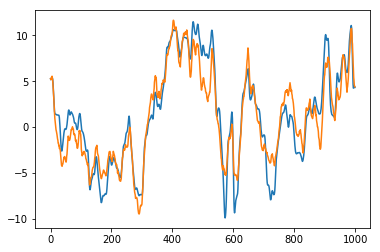

In [18]:
plt.plot(y_kf_test_all[1][0:1000,0])
plt.plot(y_pred_kf_all[1][0:1000,0])